# Model proto

This is a rough prototype of our RL solution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.dnd.game_board import DnDBoard, GameState
from src.agent.agent import DnDAgent
from src.agent.agent_utils import get_legal_action_resolver, get_states, self_play_loop

In [3]:
seed_everything(1234, deterministic_cudnn=True)

## Sample agent game

In [4]:
def ava_reward_trivial(game, data_agent, data_enemy):
    game_state, unit, player_id, move_legal, action_legal, updates = data_agent

    units_removed = updates['units_removed']
    reward = 0
    # reward for removing enemy units, 1 for each unit
    reward += len([x for x in units_removed if x[1] != player_id]) * 1
    # reward for winning
    if len(game.players_to_units[player_id]) == len(game.units):
        reward += 10
    #if data_enemy is not None and data_enemy[0] == GameState.WIN:
    #    reward -= 10
    # penalty for losing (on your own turn ??)
    if len(game.players_to_units[player_id]) == 0:
        reward = -10
    
    return reward

In [5]:
def create_same_game(board_size=(5, 5), show_game=False, get_colormap=True, reward_head=None):
    game = DnDBoard(board_size, reward_head=reward_head)

    ally = GenericSoldier("Ally soldier", attack_damage=25)
    ally2 = GenericSoldier("Ally soldier", attack_damage=25, health=50, range=4)
    #ally2 = GenericSoldier("Ally archer", health=50, attack_damage=25, speed=4, range=8)
    enemy = GenericSoldier("Enemy soldier", attack_damage=25)
    enemy2 = GenericSoldier("Enemy soldier", attack_damage=25, health=50, range=4)
    #enemy2 = GenericSoldier("Enemy archer", health=50, attack_damage=25, speed=4, range=8)
    
    place_unit_randomly(game, ally, 0)
    place_unit_randomly(game, enemy, 1)
    place_unit_randomly(game, ally2, 0)
    place_unit_randomly(game, enemy2, 1)
   
    game.initialize_game()

    if get_colormap or show_game:
        color_map = {
            ally: "Green",
            enemy: "Red",
            ally2: "Green",
            enemy2: "Red",
            #ally2: "Blue",
            #enemy2: "Purple"
        }

        if show_game: print_game(game, color_map)

        return game, color_map

    return game

In [6]:
def train_loop_ava_simple(agent: DnDAgent,
                          enemy: DnDAgent,
                          game: DnDBoard, 
                          reward_fn: callable,
                          iter_limit: int=10000) -> tuple[int, bool]:
    last_state, last_action, last_turn_info = None, None, None
    
    for iter_count in range(iter_limit):
        if game.current_player_id == 0: # agent turn
            last_state, last_action, new_coords, action = get_states(game, agent)
            last_turn_info = game.take_turn(new_coords, action, skip_illegal=True)
            game_over = last_turn_info[0] != GameState.PLAYING

            if game.current_player_id == 0: # if the next move is agent's move again, memorize current transition
                reward = reward_fn(game, last_turn_info, None)
                new_state = game.observe_board()
                agent.memorize(last_state, last_action, reward, new_state, game_over)
                agent.learn()
            
            if game_over:
                return iter_count + 1, last_turn_info[0] == GameState.WIN

        else: # enemy turn
            _, _, new_coords, action = get_states(game, enemy)
            enemy_turn_info = game.take_turn(new_coords, action, skip_illegal=True)
            game_over = enemy_turn_info[0] != GameState.PLAYING

            if game.current_player_id == 0 and last_state is not None: # if the next move is agent's, memorize the transition
                new_state = game.observe_board()
                reward = reward_fn(game, last_turn_info, enemy_turn_info)
                agent.memorize(last_state, last_action, reward, new_state, game_over)
                agent.learn()

            if game_over:
                return iter_count + 1, enemy_turn_info[0] == GameState.LOSE

    raise RuntimeError('Iteration limit exceeded')

In [7]:
ref_agent_paths = [
    '../rnd/2v2-0/trained-agents/agent-gen27-12.7i',
    '../rnd/2v2-0/trained-agents/agent-gen26-10.3i',
    '../rnd/2v2-0/trained-agents/agent-gen15-10.2i',
]

In [8]:
board_size = (5, 5)
agent = DnDAgent(board_shape=board_size, in_channels=8, out_actions=2, 
    lr=1e-3, 
    epsilon=0.1, 
    min_epsilon=0.01,
    epsilon_delta=1e-5, 
    epsilon_strategy='linear',
    gamma=0.9,
    batch_size=32, 
    dual_learning=True, 
    replace_model_interval=5000,
    memory_capacity=100000,
    random_action_resolver=get_legal_action_resolver(board_size)
)

train_loop = train_loop_ava_simple
reward_policy = ava_reward_trivial

In [9]:
reports_path = '../rnd/2v2-0/'
generation_name = 'gen30'
gen_header = \
'''# Based on gen 29

## Differences:

* Reference agent changed to 
'''

In [10]:
iters, eps, checkpoints, reps, wins = [], [], [], [], []
mag1s, mag2s = [], []

did_replace = [ False ]
def on_replace():
    global did_replace
    did_replace[0] = True
    
agent.on_replace = on_replace

ref_agents = [DnDAgent.load_agent(x, strip=True, epsilon=0) for x in ref_agent_paths]

In [11]:
agent.set_lr(1e-4)

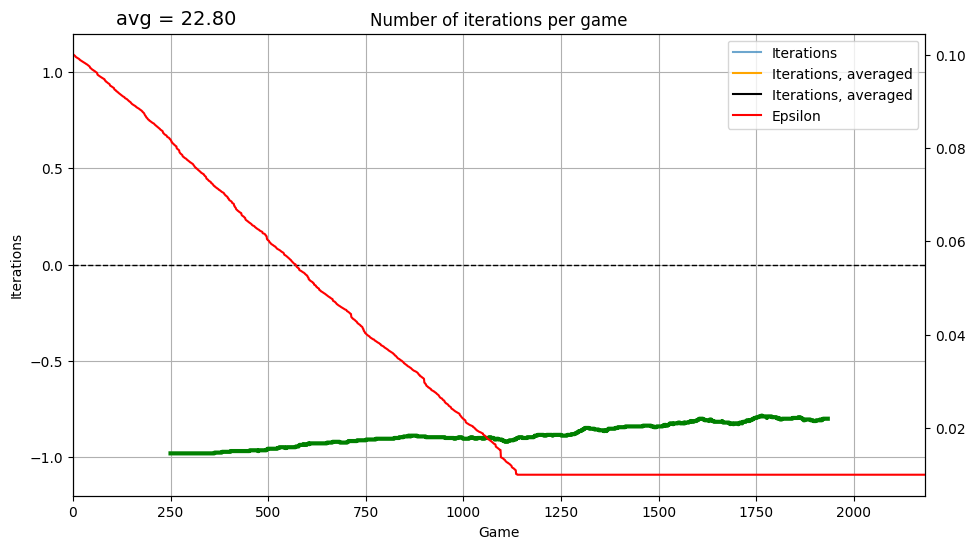

Training:  87%|########7 | 2181/2500 [03:04<00:42,  7.55it/s, mag1=0.279, mag2=0.435]

In [12]:
games = 2500
checkpoint_each = 5000
checkpoint_name = f'2v2-0-agent-{generation_name}'
if checkpoint_name is None: checkpoint_each = 1e99
last_update = -1e9
ref_agent = ref_agents[0]

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training', smoothing=0.1) as pbar:
    for i in pbar:
        game = create_same_game(board_size, get_colormap=False, reward_head=DnDBoard.passthrough_reward_head)
        outputs = agent.predict(game.observe_board())
        metric = np.mean(np.abs(outputs), axis=(1, 2))
        iter_count, win = train_loop(agent, ref_agent, game, reward_policy)
        iters.append(iter_count)
        wins.append(win)
        eps.append(agent.epsilon)
        mag1s.append(metric[0])
        mag2s.append(metric[1])
        pbar.set_postfix({'mag1': metric[0], 'mag2': metric[1]})

        ctime = time.time()
        if ctime - last_update > 30:
            clear_output(wait=True)
            # ax = plot_training_history(iters, eps, checkpoints, vlines=reps, ylim=(-1.2, 1.2), show=False)[0]
            ax = plot_training_history(iters, eps, checkpoints, ylim=(-1.2, 1.2), show=False)[0]
            n = 500
            win_conv = 2 * np.convolve(wins, np.ones(n) / n, mode='valid') - 1
            ax.plot(range(n // 2, len(win_conv) + n // 2), win_conv, label='Winrate', color='g', lw=3)
            ax.axhline(0, color='k', lw=1, linestyle='--')
            ax.grid()

            # scatter_win = np.array(wins) * 2 - 1
            # ax.scatter(range(len(iters)), scatter_win, 10, marker='x')

            plt.show()
            display(pbar.container)
            last_update = ctime

        iter_i = len(iters)
        if iter_i - last_checkpoint >= checkpoint_each:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            avg = np.mean(iters[-1000:]) # recent performance
            agent.save_agent(f'../checkpoints/{checkpoint_name}-{avg:0.1f}i-{iter_i}')

        if did_replace[0]:
            did_replace[0] = False
            reps.append(iter_i)

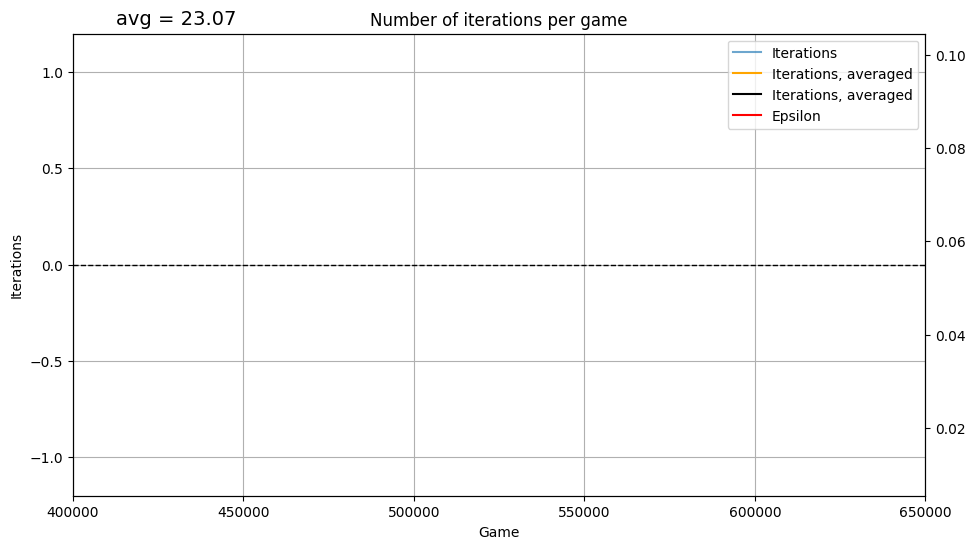

In [13]:
ax = plot_training_history(iters, eps, checkpoints, ylim=(-1.2, 1.2), xlim=(400000, 650000), show=False)[0]
n = 500
win_conv = 2 * np.convolve(wins, np.ones(n) / n, mode='valid') - 1
ax.plot(range(n // 2, len(win_conv) + n // 2), win_conv, label='Winrate', color='g', lw=3)
ax.axhline(0, color='k', lw=1, linestyle='--')
ax.grid()
plt.show()

In [14]:
export_path = os.path.join(reports_path, generation_name)
os.makedirs(export_path)

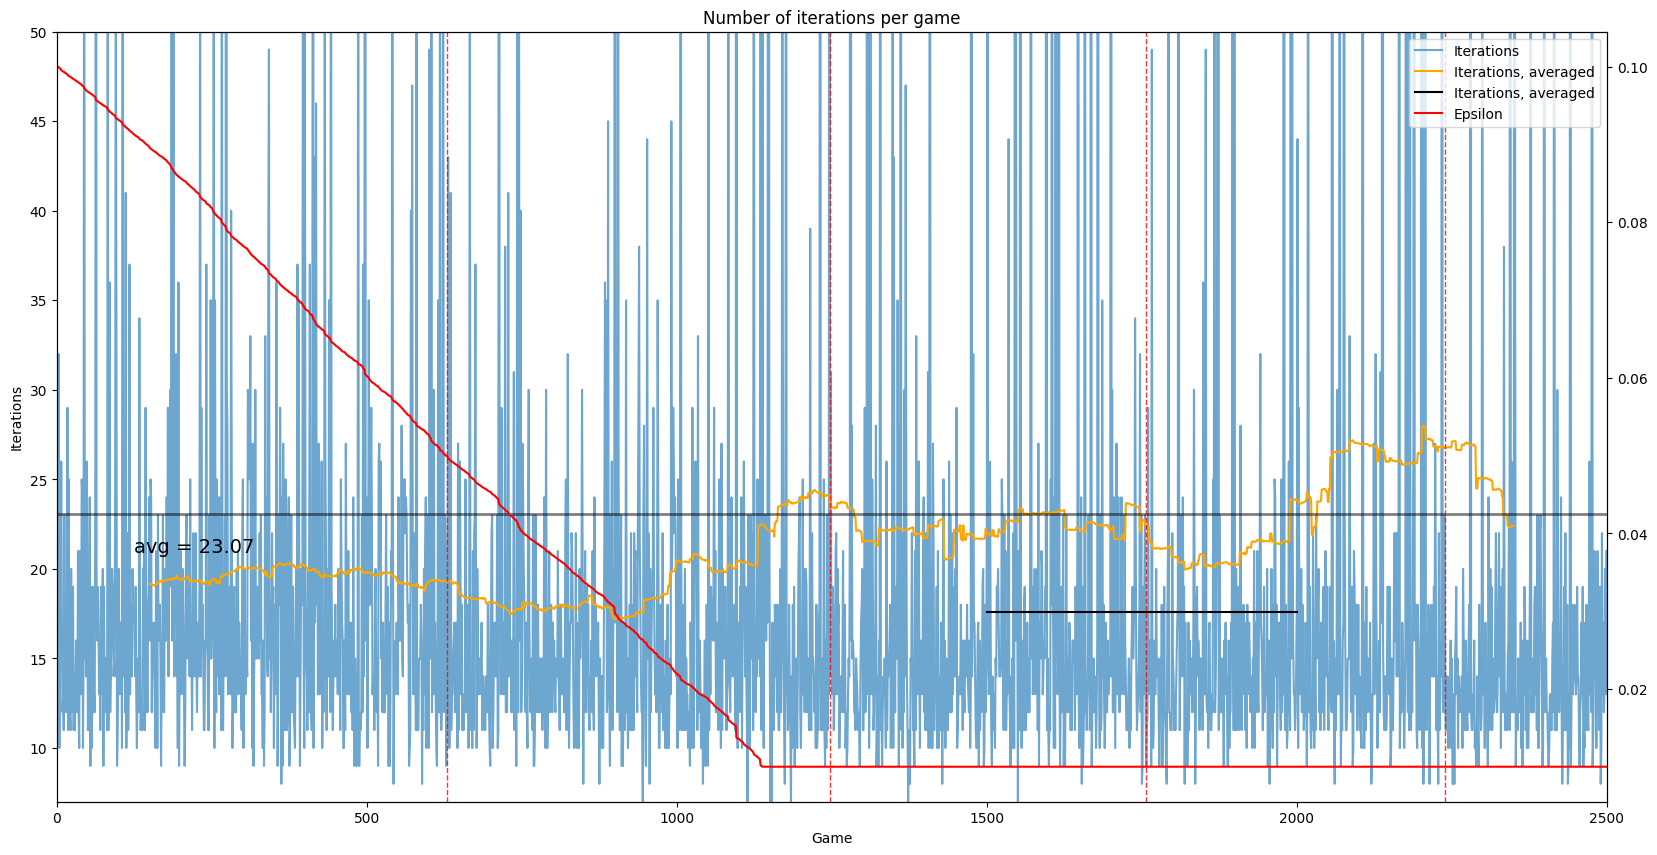

In [15]:
plot_training_history(iters, eps, checkpoints, vlines=reps, ylim=50, figsize=(20, 10), show=False)
plt.savefig(os.path.join(export_path, 'training.png'), bbox_inches='tight')
plt.show()

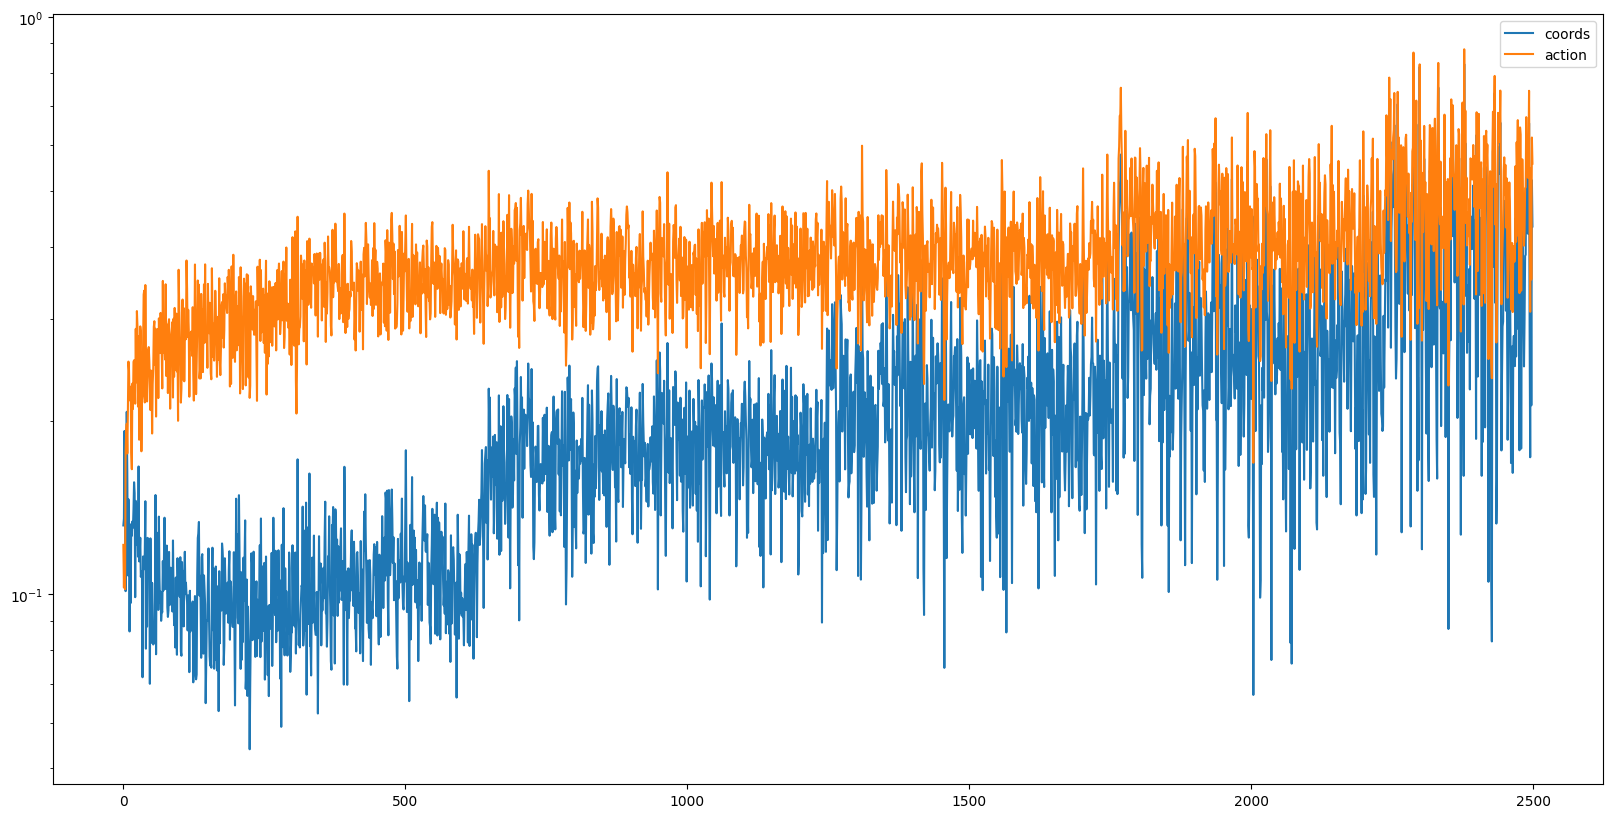

Total number of iterations: 52818


In [16]:
plt.figure(figsize=(20, 10))
plt.plot(mag1s[:650000], label='coords')
plt.plot(mag2s[:650000], label='action')
plt.yscale('log')
plt.legend()
plt.savefig(os.path.join(export_path, 'magnitude.png'), bbox_inches='tight')
plt.show()
print(f'Total number of iterations: {np.sum(iters)}')

In [17]:
with open(os.path.join(export_path, 'report.md'), 'w') as report:
    avg = np.mean(iters[-1000:])
    total = np.sum(iters)
    perf = 1e9 / (avg * total)
    report.write(
f'''{gen_header}
# Results
![image](training.png "")

* Average iteration count after 20k games: {avg:0.2f}
* Total iterations performed: {total}
* Relative training performance: {perf:0.2f}
> 1e9 / (total_iter * avg_iter)

## Model's outputs magnitude history:

![magnitudes](magnitude.png "")
''')

In [18]:
print(f'Shortest game: {np.min(iters)}')
print(f'Longest game: {np.max(iters)}')
print(f'Number of shortest games: {np.sum(np.array(iters) == np.min(iters))}')

Shortest game: 7
Longest game: 714
Number of shortest games: 7


In [19]:
game, color_map = create_same_game()

self_play_loop(agent, game, color_map, reset_epsilon=True, delay=1)

Iteration: 192
Turn made by player #0: `Ally soldier`:
	Unit moves: (3, 2) -> (2, 0);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Ally soldier', 'target_unit': 'None'}

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally soldier (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy soldier (50 HP)`  
	
    0 1 2 3 4
 0            0 
 1         ██ 1 
 2 ██         2 
 3     ██  ██ 3 
 4            4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`

Game interrupted after 193 iterations


# Visualization

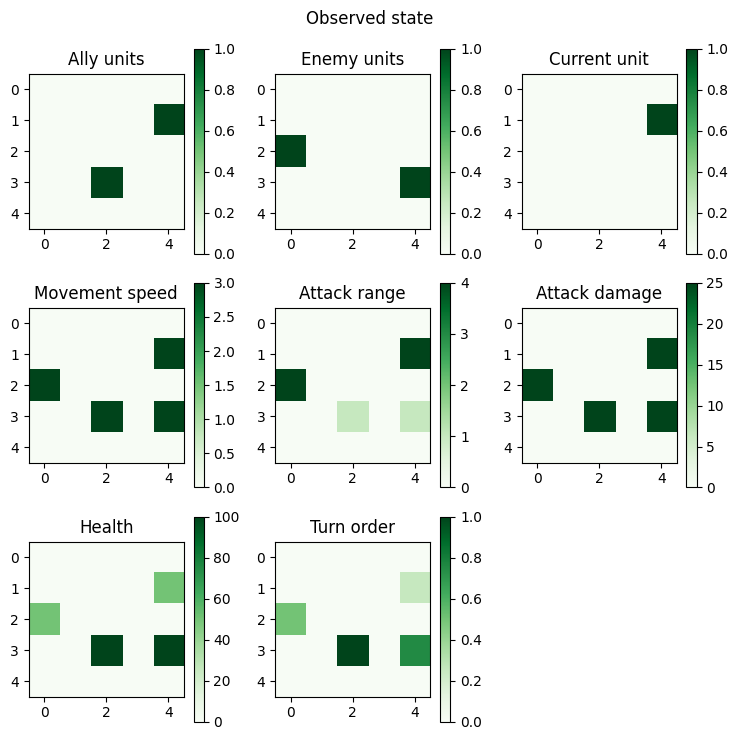

In [20]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.CHANNEL_NAMES,
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [21]:
game, color_map = create_same_game()
agent.game = game
print_game(game, color_map)

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally soldier (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy soldier (50 HP)`  
	
    0 1 2 3 4
 0 ██    ██   0 
 1            1 
 2            2 
 3            3 
 4 ████       4 
    0 1 2 3 4

Next move is by player #1: `Enemy soldier`


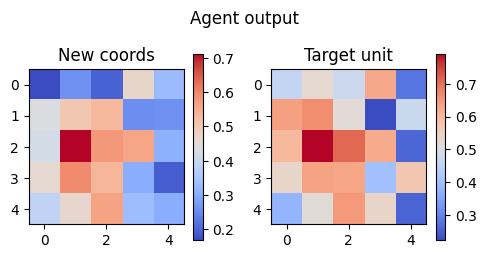

(array([2, 2], dtype=int64), array([1, 1], dtype=int64))


In [22]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action_vector(state))